In [1]:
%config IPCompleter.greedy=True

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [3]:
#test utils
import weapon_data as weapons

def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded, _ = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)
            
            
def get_weapon_data():
    return weapons.get_data(2, 13, 0)

In [4]:
network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=8,
         n_hidden_2=0,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.AdamOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = tf.nn.elu
num_epochs = 20
batch_size = 5
epoch_debug_step = 1
    
with tf.Session() as sess:
    train_data, test_data = get_weapon_data()
    network_architecture['n_input'] = train_data.num_features
  
    network = vae.get_new_trained(sess, train_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step)


Epoch:0001 - Cost:21.842238697
Epoch:0002 - Cost:19.848203058
Epoch:0003 - Cost:17.585138411
Epoch:0004 - Cost:16.193325726
Epoch:0005 - Cost:15.926332774
Epoch:0006 - Cost:15.006283738
Epoch:0007 - Cost:15.697696228
Epoch:0008 - Cost:14.240050635
Epoch:0009 - Cost:14.954093498
Epoch:0010 - Cost:14.232156558
Epoch:0011 - Cost:15.229488977
Epoch:0012 - Cost:13.795639887
Epoch:0013 - Cost:15.454482131
Epoch:0014 - Cost:13.712503816
Epoch:0015 - Cost:13.780254586
Epoch:0016 - Cost:15.503638279
Epoch:0017 - Cost:13.291737076
Epoch:0018 - Cost:15.055843113
Epoch:0019 - Cost:13.825908158
Epoch:0020 - Cost:14.991565389
Trained model saved! You can find it in './trained_vae/model.ckpt'


In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
        
    train_data, test_data = get_weapon_data()
    samples = test_data.next_batch(1)
    x_reconstructed = network.encode_and_decode(samples)
    
    print(samples)
    print(x_reconstructed)
    
    print_decoded_tensors_as_dict(test_data, np.concatenate((samples,x_reconstructed), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
[[ 0.82948142  0.60118691  2.88712045  0.99569425 -0.26352316 -1.04880885
   1.58113883 -0.48507125 -1.32959555  0.82220467 -0.26424317  0.4513875
  -0.57240795 -0.48010721 -0.97777561 -0.32444284 -0.32444284 -0.48507125
   1.78885438 -0.32444284 -0.40824829 -0.55901699]]
[[ 0.7031001   0.64624727  0.05566801  0.62742066  0.17186983 -1.040858
   0.33377224  0.6960973  -0.8481591   0.60532045  0.8005972  -0.02589207
  -0.6600765  -0.37669513 -1.0231197   0.1745204   0.17777975  0.09396543
   0.09841312 -0.684531    0.62767076 -0.57385296]
 [-0.13713601 -0.31949484  0.6504114  -0.22615746  0.35303712 -0.9776425
   1.1687627  -0.26226085 -0.7670846  -0.047024    0.17143738 -0.5291935
  -0.7597146  -0.6277039  -0.5216725   0.33432707  0.31459472  0.5767135
   0.6257733  -0.56471956 -0.3743135  -0.7777812 ]
 [-0.03314753 -0.20980506  0.5540999  -0.12134199  0.3627721  -0.9404888
   1.0106913  -0.12749887 -0.75265795  0.0708661

In [6]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    _, test_data = get_weapon_data()
    num_samples = test_data.num_examples
    
    batch_size = 1
    avg_cost = 0.
    avg_distance_norm = 0
    avg_distance_unnorm = 0
    for i in range(num_samples):
        batch = test_data.next_batch(1)

        x_reconstructed = network.encode_and_decode(samples)
        cost = network.calculate_loss(batch)
        
        #print(batch[0])
        _, unstandardized_batch = test_data.decode_processed_tensor(batch[0])
        _, unstandardized_x = test_data.decode_processed_tensor(x_reconstructed[0])
        distance_unnorm = (sess.run(tf.reduce_sum(tf.abs(unstandardized_batch - unstandardized_x))))
        
        distance_norm = (sess.run(tf.reduce_sum(tf.abs(batch[0] - x_reconstructed[0]))))
        #print(cost)

        #compute average loss/cost
        avg_cost += cost / num_samples
        avg_distance_unnorm += distance_unnorm / num_samples
        avg_distance_norm += distance_norm / num_samples
    
    print("Average cost = " + "{:.9f}".format(avg_cost))
    print("Average unnormalized distance = " + "{:.9f}".format(avg_distance_unnorm))
    print("Average normalized distance = " + "{:.9f}".format(avg_distance_norm))


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Average cost = 14.736269633
Average unnormalized distance = 515.639769821
Average normalized distance = 18.420588287


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


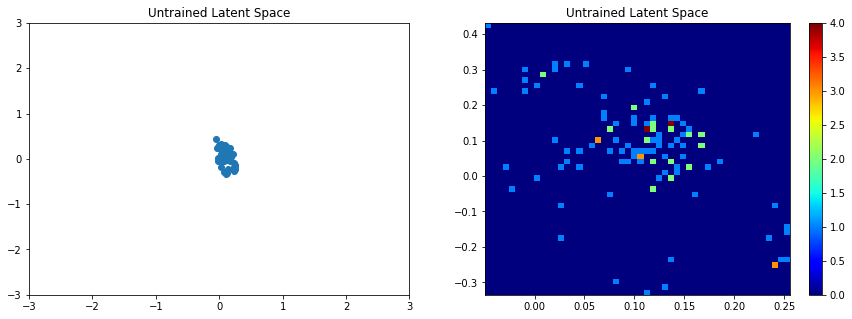

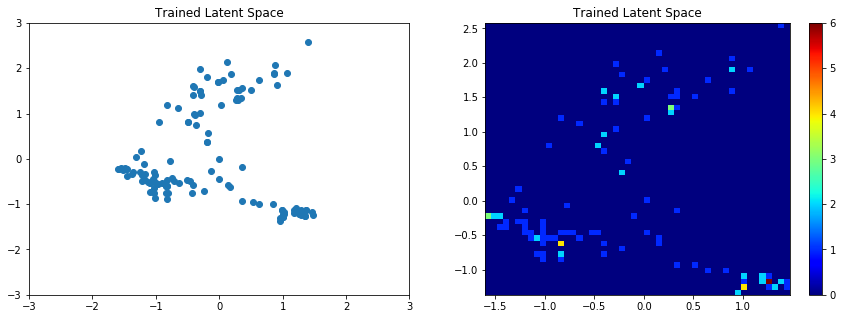

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_z_distribution(vae_model, title, z_mean=True):
    all_z = np.zeros((1,network_architecture['n_z']))
        
    train_data, test_data = get_weapon_data()
    total_batch = int(train_data.num_examples / batch_size) 

    # Loop over all batches
    for i in range(total_batch):
        batch = train_data.next_batch(batch_size)
        z_dist = vae_model.calculate_z(batch)
        if z_mean:
            z_dist = vae_model.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_dist))

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(all_z[:,0], all_z[:,1])
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(title)
    plt.subplot(1,2,2)
    plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.title(title)
    
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    show_z_distribution(network, "Untrained Latent Space", z_mean=True)
    network = vae.restore(network, "trained_vae/model.ckpt")
    show_z_distribution(network, "Trained Latent Space", z_mean=True)

In [8]:
# Testing
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []
    for i in range(4):
        random_val = np.random.normal(size=(1,network_architecture["n_z"]))
        x_test = network.decode_from_latent_space(random_val)
        generated.append(x_test[0])
        
    train_data, test_data = get_weapon_data()
    print_decoded_tensors_as_dict(train_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['44.78603008583234', '43.33383506417148', '41.87220580074771', '52.48577830104137']
damages_last = ['31.829267404562486', '26.44379690805361', '28.392803260573714', '36.65332505808173']
dmg_distances_first = ['11.27140186328564', '21.86867776459228', '12.64339679546138', '21.103020429155368']
dmg_distances_last = ['63.770749593555855', '57.39997533258708', '58.712197755694376', '72.8311893641925']
drag = ['0.0029004829016362455', '0.003219096995260971', '0.002948482212373928', '0.0030724630981439913']
firemode_Automatic = ['0.5826481184213063', '0.012514386367965369', '0.5737631675800646', '-0.18286941681411711']
firemode_Semi-Automatic = ['0.10418019138457751', '0.7630191237252554', '0.17175048363119658', '0.7859579848601259']
hiprecoildec = ['6.476250192932279', '3.787417117210449', '6.425030181586825', '2.94988957804142']
hiprecoilright = ['0.6572675528845016', '0.6327241226691229', '0.6265956305245035